In [1]:
%load_ext Cython

In [2]:
no_learning = pd.DataFrame.from_csv('./data/no_learning.cvs')
learning = pd.DataFrame.from_csv('./data/learning.cvs')

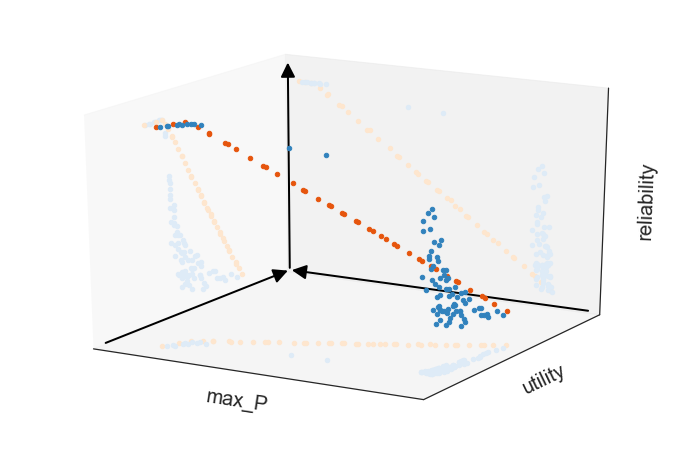

In [3]:
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.patches import FancyArrowPatch
from mpl_toolkits.mplot3d import proj3d
import seaborn as sns

class Arrow3D(FancyArrowPatch):
    def __init__(self, xs, ys, zs, *args, **kwargs):
        FancyArrowPatch.__init__(self, (0,0), (0,0), *args, **kwargs)
        self._verts3d = xs, ys, zs

    def draw(self, renderer):
        xs3d, ys3d, zs3d = self._verts3d
        xs, ys, zs = proj3d.proj_transform(xs3d, ys3d, zs3d, renderer.M)
        self.set_positions((xs[0],ys[0]),(xs[1],ys[1]))
        FancyArrowPatch.draw(self, renderer)

sns.set_style('white')

# Axes limits
pholims = (0, 2.6)
utilims = (-0.5, 2.6)
rellims = (0, 1.1)

# plotting
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

# setup plot
ax.view_init(elev=20, azim=120)
ax.set_xlim(pholims)
ax.set_ylim(utilims)
ax.set_zlim(rellims)
ax.set_yticks([])
ax.set_xticks([])
ax.set_zticks([])

x_arrow = Arrow3D(pholims, [utilims[1], utilims[1]], [0, 0],
                  mutation_scale = 30, lw=2, arrowstyle="<|-", color="k")
y_arrow = Arrow3D([pholims[0],pholims[0]], utilims, [0, 0],
                  mutation_scale = 30, lw=2, arrowstyle="-|>", color="k")
z_arrow = Arrow3D([0,0], [utilims[1], utilims[1]], rellims,
                  mutation_scale = 30, lw=2, arrowstyle="-|>", color="k")
ax.add_artist(x_arrow)
ax.add_artist(y_arrow)
ax.add_artist(z_arrow)

ax.set_xlabel("max_P", fontsize=20)
ax.set_ylabel("utility", fontsize=20)
ax.set_zlabel("reliability", fontsize=20)

plt.gca().invert_yaxis()
plt.gca().invert_xaxis()

def plot_data(ax, x, y, z, main_color, shade_color):

    ax.scatter(x, y, z, c=main_color, depthshade=False)

    ax.scatter(x, z, c=shade_color, zdir='y', zs=utilims[1], depthshade=False)
    ax.scatter(y, z, c=shade_color, zdir='x', zs=pholims[0], depthshade=False)
    ax.scatter(x, y, c=shade_color, zdir='z', zs=-0.1, depthshade=False)

# plotting no learning
x_no_learning = no_learning['max_P']
y_no_learning = no_learning['utility']
z_no_learning = no_learning['reliability']
plot_data(ax, x_no_learning, y_no_learning, z_no_learning, '#3182bd', '#deebf7')

# plotting learning
x_learning = learning['max_P']
y_learning = learning['utility']
z_learning = learning['reliability']
plot_data(ax, x_learning, y_learning, z_learning, '#e6550d', '#fee6ce')

plt.show()

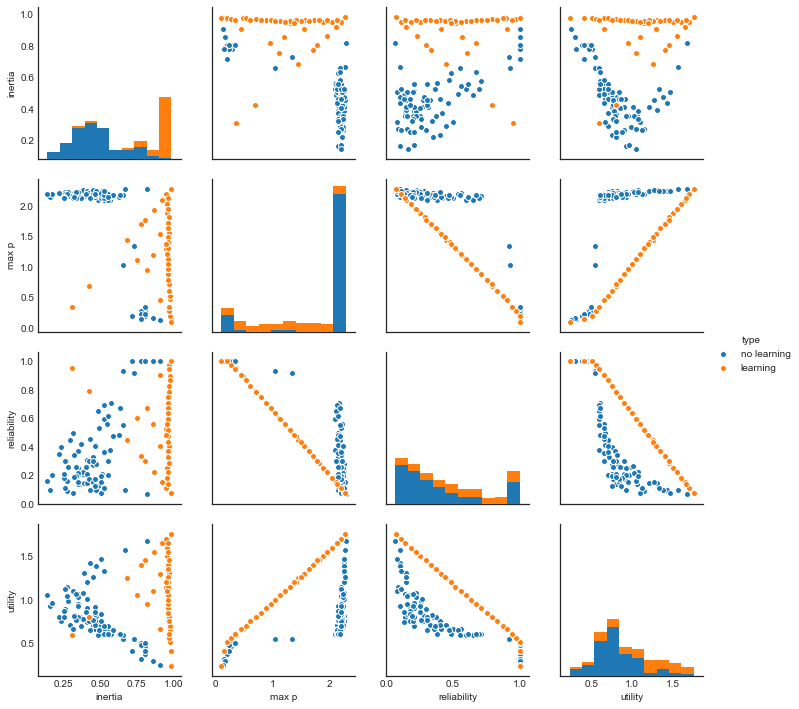

In [4]:
complete_x = np.concatenate((x_no_learning, x_learning))
complete_y = np.concatenate((y_no_learning, y_learning))
complete_z = np.concatenate((z_no_learning, z_learning))
complete_inertia = np.concatenate((no_learning['inertia'], learning['inertia']))
labeling = np.asarray(['no learning',]*x_no_learning.shape[0]+['learning',]*x_learning.shape[0])
data = {'max p':complete_x, 'utility':complete_y, 'reliability':complete_z, 
        'inertia':complete_inertia, 'type':labeling}

combined = pd.DataFrame(data)

sns.pairplot(combined, hue='type')
plt.show()

# Evaluation under deep uncertainty

## common pieces

In [7]:
# generate policies from optimization results
from ema_workbench import (Policy, ema_logging, MultiprocessingEvaluator, 
                           ema_logging)
from ema_workbench.em_framework.model import Replicator, BaseModel
from ema_workbench.em_framework import sample_uncertainties

ema_logging.log_to_stderr(ema_logging.INFO)

# replicator model class definition
class ReplicatorModel(Replicator, BaseModel):
    pass

def to_policies(optimization_results, basename):
    levers = optimization_results.drop(['max_P', 'utility', 'inertia', 'reliability'], axis=1)
    policies = []
    for i, entry in levers.iterrows():
        policy = Policy(str('{}_{}'.format(basename, i)), **entry.to_dict())
        policies.append(policy)
        
    return policies

n_scenarios = 100

## no learning

In [8]:
%%cython

import numpy as np
from scipy.optimize import brentq

cimport cython
cimport numpy as np
from libc.math cimport log, sqrt

ctypedef np.float_t DTYPE_t


@cython.cdivision(True)
@cython.boundscheck(False) 
def cython_lake_model(float b=0.42, float q=2.0, float mean=0.02, 
                      float stdev=0.001, float alpha=0.4, float delta=0.98, 
                      int nsamples=100, int steps=100, **kwargs):    
    '''runs the lake model for 1 stochastic realisation using specified 
    random seed.
        
    Parameters
    ----------
    b : float
        decay rate for P in lake (0.42 = irreversible)
    q : float
        recycling exponent
    mean : float
            mean of natural inflows
    stdev : float
            standard deviation of natural inflows
    alpha : float
            utility from pollution
    delta : float
            future utility discount rate
    steps : int
            the number of time steps (e.g., days)
    seed : int, optional
           seed for the random number generator
    
    '''
    cdef float Pcrit, reliability, utility, inertia, transformed_mean, transformed_sigma
    cdef int t, i
    cdef np.ndarray[DTYPE_t, ndim=1] X = np.zeros([steps,], dtype=np.float)
    cdef np.ndarray[DTYPE_t, ndim=1] decisions = np.zeros([steps,], dtype=np.float)
    cdef np.ndarray[DTYPE_t, ndim=1] natural_inflows 
    
    for i in range(steps):
        decisions[i] = kwargs[str(i)]
    
    Pcrit = brentq(lambda x: x**q/(1+x**q) - b*x, 0.01, 1.5)
    
    transformed_mean = log(mean**2 / sqrt(stdev**2 + mean**2))
    transformed_sigma = sqrt(log(1.0 + stdev**2 / mean**2))
    natural_inflows = np.random.lognormal(transformed_mean, transformed_sigma, size=steps)

    for t in range(1, steps):
        X[t] = (1-b)*X[t-1] + X[t-1]**q/(1+X[t-1]**q) + decisions[t-1] + natural_inflows[t-1]

    reliability = np.sum(X < Pcrit)/steps
    utility = np.sum(alpha*decisions*np.power(delta,np.arange(steps)))
    inertia = np.sum(np.abs(np.diff(decisions)) < 0.01)/(steps-1)
    return X, utility, inertia, reliability

/Domain/tudelft.net/Users/jhkwakkel/anaconda/lib/python3.6/importlib/_bootstrap.py:205: ImportWarning: can't resolve package from __spec__ or __package__, falling back on __name__ and __path__
  return f(*args, **kwds)


In [9]:
from ema_workbench import (RealParameter, ScalarOutcome, Constant)

lake_model = ReplicatorModel('lakeproblem', function=cython_lake_model)
lake_model.replications = 150

#specify uncertainties
lake_model.uncertainties = [RealParameter('b', 0.1, 0.45),
                            RealParameter('q', 2.0, 4.5),
                            RealParameter('mean', 0.01, 0.05),
                            RealParameter('stdev', 0.001, 0.005),
                            RealParameter('delta', 0.93, 0.99)]

# set levers
lake_model.levers = [RealParameter(str(i), 0, 0.1) for i in range(100)]

def process_p(values):
    values = np.asarray(values)
    values = np.mean(values, axis=0)
    return np.max(values)

#specify outcomes 
lake_model.outcomes = [ScalarOutcome('max_P', 
                                     kind=ScalarOutcome.MINIMIZE,
                                     function=process_p
                                    ),
                       ScalarOutcome('utility', 
                                     kind=ScalarOutcome.MAXIMIZE,
                                     function=np.mean
                                    ),
                       ScalarOutcome('inertia', 
                                     kind=ScalarOutcome.MAXIMIZE,
                                     function=np.mean
                                    ),
                       ScalarOutcome('reliability', 
                                     kind=ScalarOutcome.MAXIMIZE,
                                     function=np.mean
                                    )]

# override some of the defaults of the model
lake_model.constants = [Constant('alpha', 0.41),
                        Constant('nsamples', 100),
                        Constant('steps', 100)]

In [10]:
policies = to_policies(no_learning, 'no_learning')
scenarios = sample_uncertainties(lake_model, n_scenarios)

In [11]:
with MultiprocessingEvaluator(lake_model) as evaluator:
    no_learning_results = evaluator.perform_experiments(scenarios, policies)

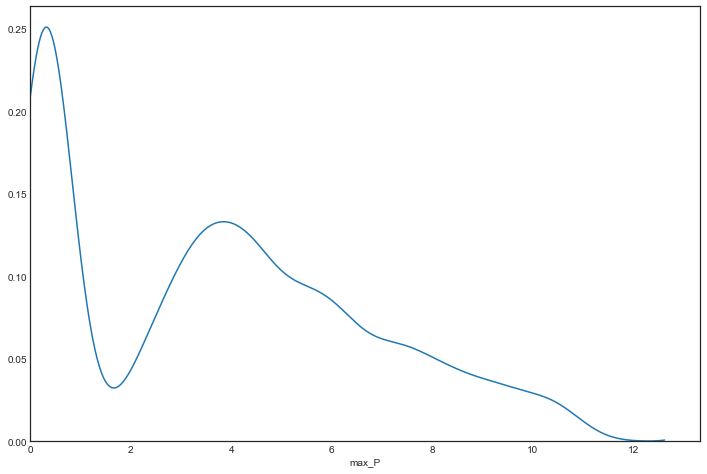

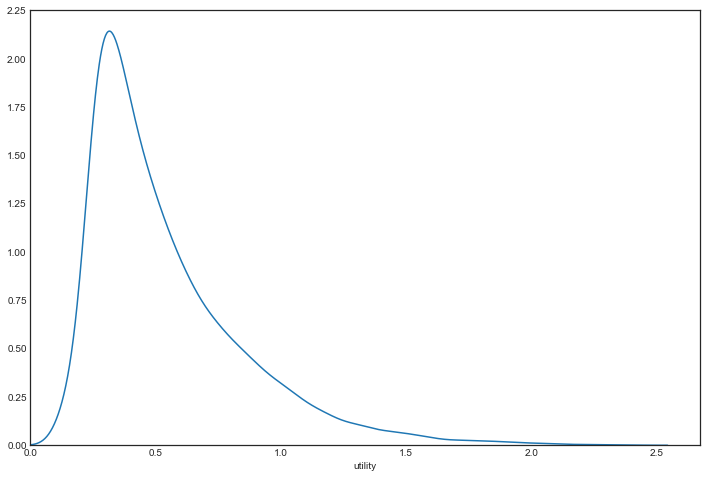

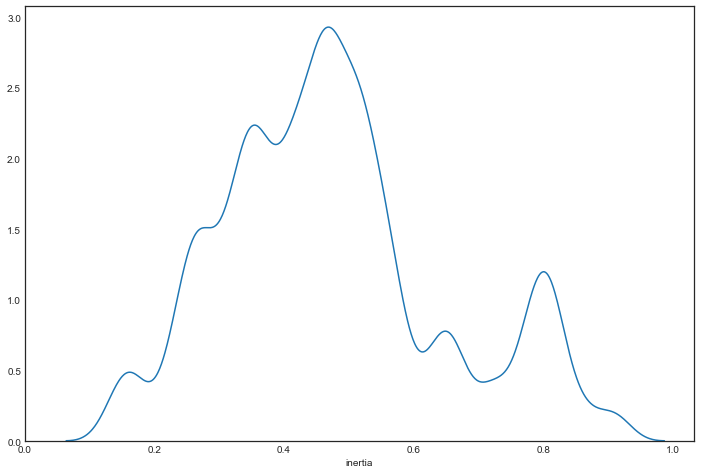

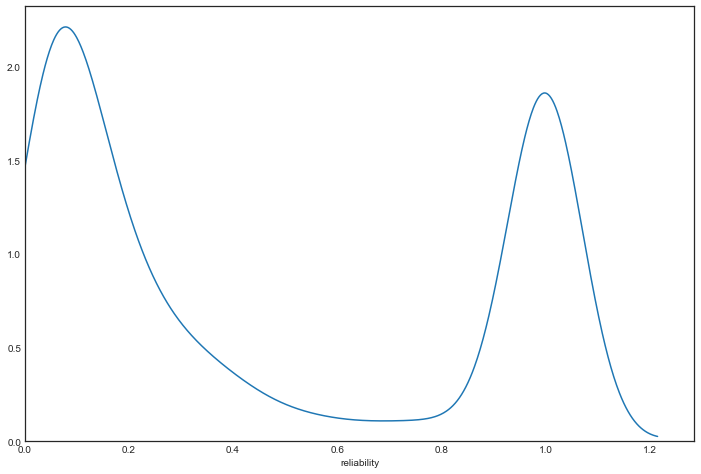

In [12]:
experiments, outcomes = no_learning_results

for outcome in outcomes.keys():
    fig = plt.figure()
    
    sns.kdeplot(outcomes[outcome], gridsize=1000)
    ax = plt.gca()
    ax.set_xlabel(outcome)
    ax.set_xlim(xmin=0)
plt.show()

/Domain/tudelft.net/Users/jhkwakkel/anaconda/lib/python3.6/site-packages/statsmodels/nonparametric/kde.py:494: RuntimeWarning: invalid value encountered in true_divide
  binned = fast_linbin(X,a,b,gridsize)/(delta*nobs)
/Domain/tudelft.net/Users/jhkwakkel/anaconda/lib/python3.6/site-packages/statsmodels/nonparametric/kdetools.py:34: RuntimeWarning: invalid value encountered in double_scalars
  FAC1 = 2*(np.pi*bw/RANGE)**2


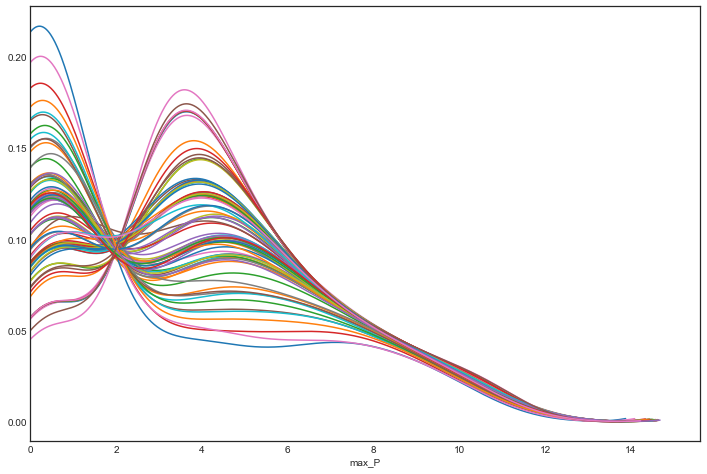

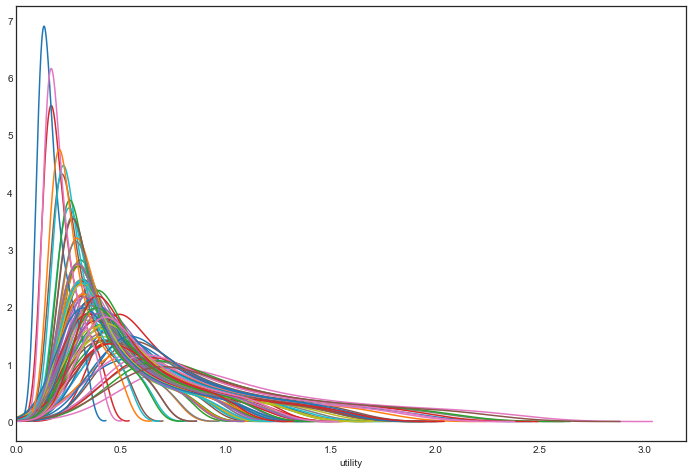

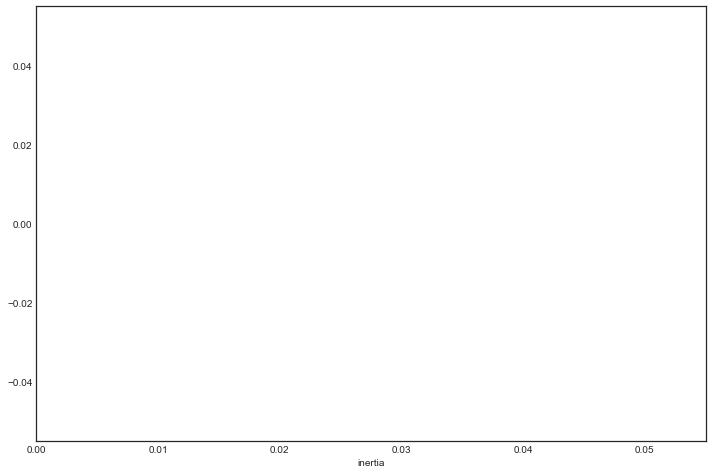

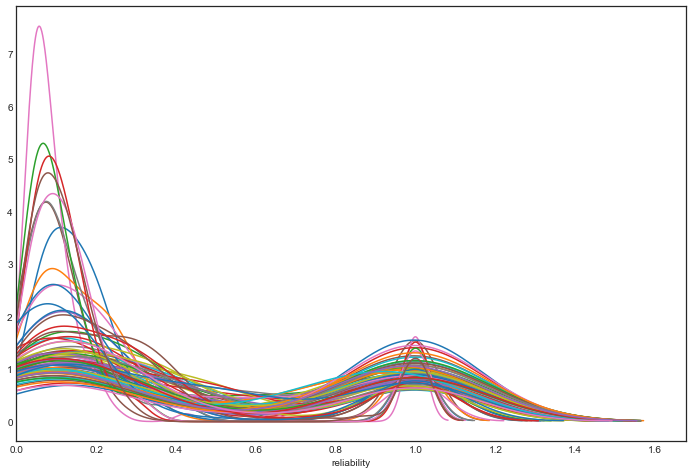

In [13]:
for i, outcome in enumerate(outcomes.keys()):
    fig = plt.figure()

    for policy in set(experiments['policy']):
        logical = experiments['policy']==policy
        data = outcomes[outcome][logical]
        sns.kdeplot(data, gridsize=1000)
    
    ax = plt.gca()
    ax.set_xlabel(outcome)
    ax.autoscale(True)
    ax.set_xlim(xmin=0)

    
plt.show()

## learning

In [14]:
%%cython

import numpy as np
from scipy.optimize import brentq

cimport cython
cimport numpy as np
from libc.math cimport log, sqrt

cdef inline float float_max(float a, float b): return a if a >= b else b
cdef inline float float_min(float a, float b): return a if a <= b else b

ctypedef np.float_t DTYPE_t

@cython.cdivision(True)
cpdef float cython_get_antropogenic_release(float xt, float c1, float c2, float r1, 
                             float r2, float w1):
    '''
    
    Parameters
    ----------
    xt : float
         polution in lake at time t
    c1 : float
         center rbf 1
    c2 : float
         center rbf 2
    r1 : float
         ratius rbf 1
    r2 : float
         ratius rbf 2
    w1 : float
         weight of rbf 1
         
    note:: w2 = 1 - w1
    
    '''
    cdef float rule, at, var1, var2, test
    
    var1 = (xt-c1)/r1
    var1 = abs(var1)
    var2 = (xt-c2)/r2
    var2 = abs(var2)
    
    rule = w1*(var1**3)+(1-w1)*(var2**3)
    at = float_min(float_max(rule, 0.01), 0.1)
    return at
    
@cython.cdivision(True)
@cython.boundscheck(False) 
def cython_lake_model(float b=0.42, float q=2.0, float mean=0.02, float stdev=0.001, 
               float alpha=0.4, float delta=0.98, float c1=0.25,
               float c2=0.25, float r1=0.5, float r2=0.5, float w1=0.5, 
               int nsamples=100, int steps=100):    
    '''runs the lake model for 1 stochastic realisation using specified 
    random seed.
        
    Parameters
    ----------
    b : float
        decay rate for P in lake (0.42 = irreversible)
    q : float
        recycling exponent
    mean : float
            mean of natural inflows
    stdev : float
            standard deviation of natural inflows
    alpha : float
            utility from pollution
    delta : float
            future utility discount rate
    c1 : float
    c2 : float
    r1 : float
    r2 : float
    w1 : float
    steps : int
            the number of time steps (e.g., days)
    seed : int, optional
           seed for the random number generator
    
    '''
    cdef float Pcrit, reliability, utility, inertia, transformed_mean, transformed_sigma
    cdef int t
    cdef np.ndarray[DTYPE_t, ndim=1] X = np.zeros([steps,], dtype=np.float)
    cdef np.ndarray[DTYPE_t, ndim=1] decisions = np.zeros([steps,], dtype=np.float)
    cdef np.ndarray[DTYPE_t, ndim=1] natural_inflows 
    
#     np.random.seed(seed)
    Pcrit = brentq(lambda x: x**q/(1+x**q) - b*x, 0.01, 1.5)
    
    transformed_mean = log(mean**2 / sqrt(stdev**2 + mean**2))
    transformed_sigma = sqrt(log(1.0 + stdev**2 / mean**2))
    natural_inflows = np.random.lognormal(transformed_mean, transformed_sigma, size=steps)

    for t in range(1, steps):
        decisions[t-1] = cython_get_antropogenic_release(X[t-1], c1, c2, r1, r2, 
                                                  w1)
        X[t] = (1-b)*X[t-1] + X[t-1]**q/(1+X[t-1]**q) + decisions[t-1] + natural_inflows[t-1]

    reliability = np.sum(X < Pcrit)/steps
    utility = np.sum(alpha*decisions*np.power(delta,np.arange(steps)))
    inertia = np.sum(np.abs(np.diff(decisions)) > 0.01)/(steps-1)
    return X, utility, inertia, reliability

In [15]:
from ema_workbench import (RealParameter, ScalarOutcome, Constant)
from ema_workbench.em_framework.model import Replicator, BaseModel

lake_model = ReplicatorModel('lakeproblem', function=cython_lake_model)
lake_model.replications = 150

#specify uncertainties
lake_model.uncertainties = [RealParameter('b', 0.1, 0.45),
                            RealParameter('q', 2.0, 4.5),
                            RealParameter('mean', 0.01, 0.05),
                            RealParameter('stdev', 0.001, 0.005),
                            RealParameter('delta', 0.93, 0.99)]

# set levers
lake_model.levers = [RealParameter("c1", -2, 2),
                     RealParameter("c2", -2, 2),
                     RealParameter("r1", 0, 2), 
                     RealParameter("r2", 0, 2), 
                     RealParameter("w1", 0, 1)
                     ]

def process_p(values):
    values = np.asarray(values)
    values = np.mean(values, axis=0)
    return np.max(values)

#specify outcomes 
lake_model.outcomes = [ScalarOutcome('max_P', 
                                     kind=ScalarOutcome.MINIMIZE,
                                     function=process_p),
                       ScalarOutcome('utility', 
                                     kind=ScalarOutcome.MAXIMIZE,
                                     function=np.mean),
                       ScalarOutcome('inertia', 
                                     kind=ScalarOutcome.MAXIMIZE,
                                     function=np.mean),
                       ScalarOutcome('reliability', 
                                     kind=ScalarOutcome.MAXIMIZE,
                                     function=np.mean)]

# override some of the defaults of the model
lake_model.constants = [Constant('alpha', 0.41),
                        Constant('nsamples', 100),
                        Constant('steps', 100)]

In [16]:
policies = to_policies(learning, 'learning')

In [17]:
with MultiprocessingEvaluator(lake_model) as evaluator:
    learning_results = evaluator.perform_experiments(scenarios, policies)

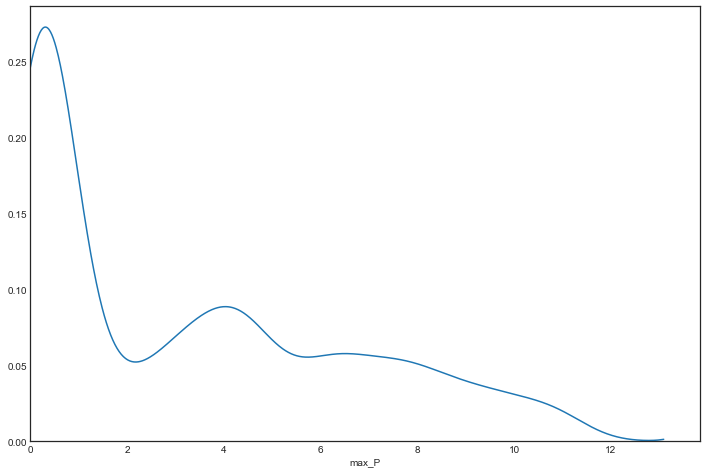

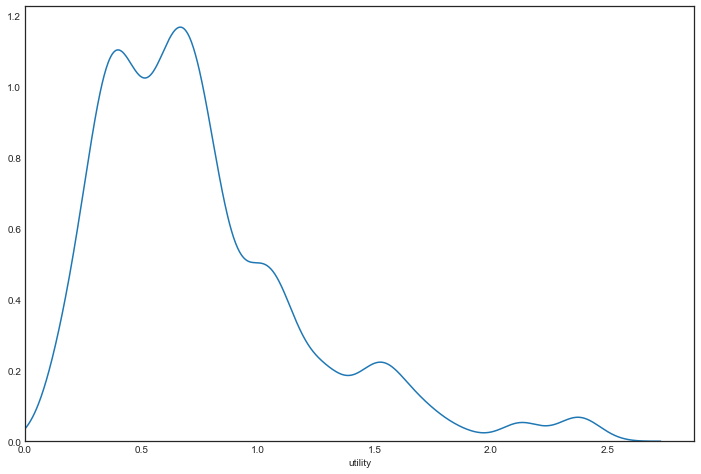

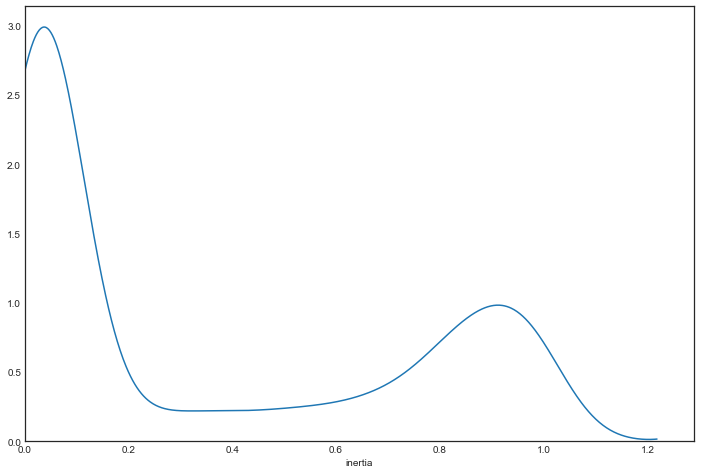

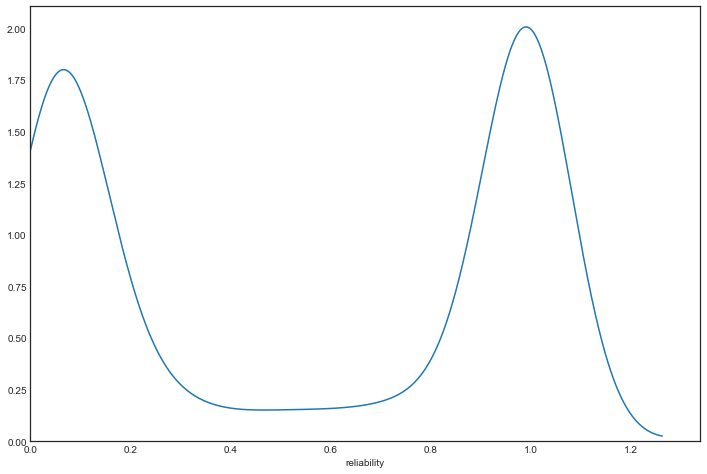

In [18]:
experiments, outcomes = learning_results

for outcome in outcomes.keys():
    fig = plt.figure()
    
    sns.kdeplot(outcomes[outcome], gridsize=1000)
    ax = plt.gca()
    ax.set_xlabel(outcome)
    ax.set_xlim(xmin=0)
plt.show()

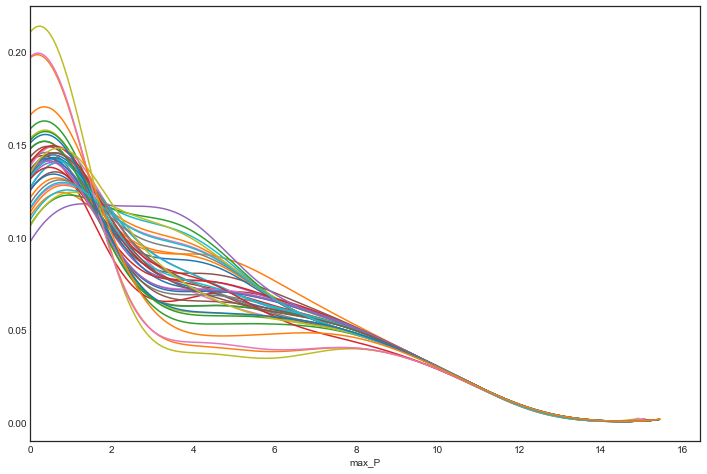

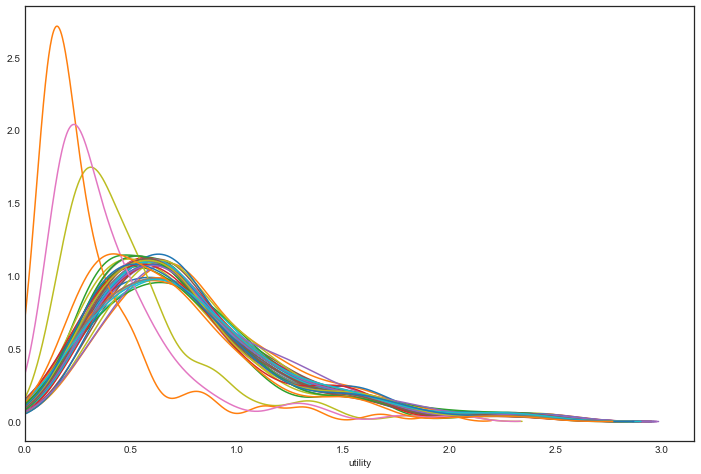

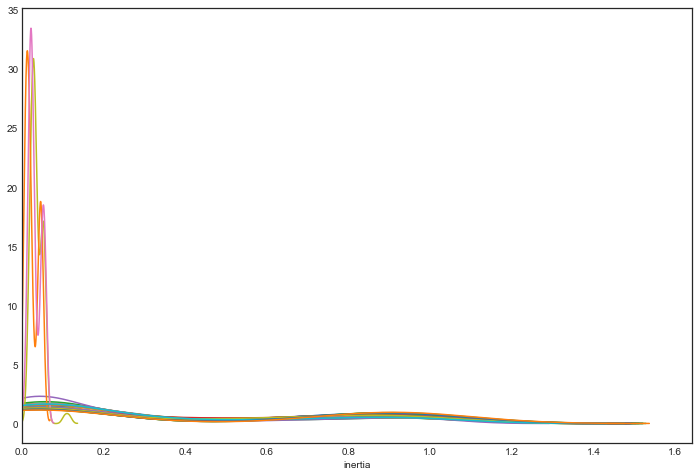

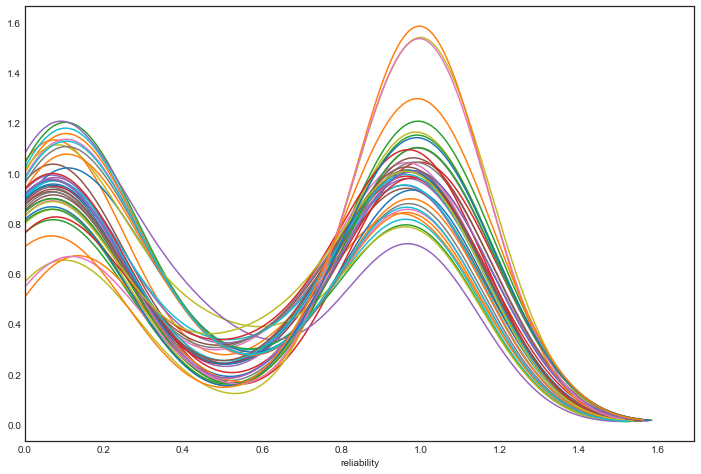

In [19]:
experiments, outcomes = learning_results

for i, outcome in enumerate(outcomes.keys()):
    fig = plt.figure()

    for policy in set(experiments['policy']):
        logical = experiments['policy']==policy
        data = outcomes[outcome][logical]
        sns.kdeplot(data, gridsize=1000)
    
    ax = plt.gca()
    ax.set_xlabel(outcome)
    ax.autoscale(True)
    ax.set_xlim(xmin=0)
    
plt.show()

## comparison under deep uncertainty

/Domain/tudelft.net/Users/jhkwakkel/anaconda/lib/python3.6/site-packages/matplotlib/axes/_axes.py:545: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


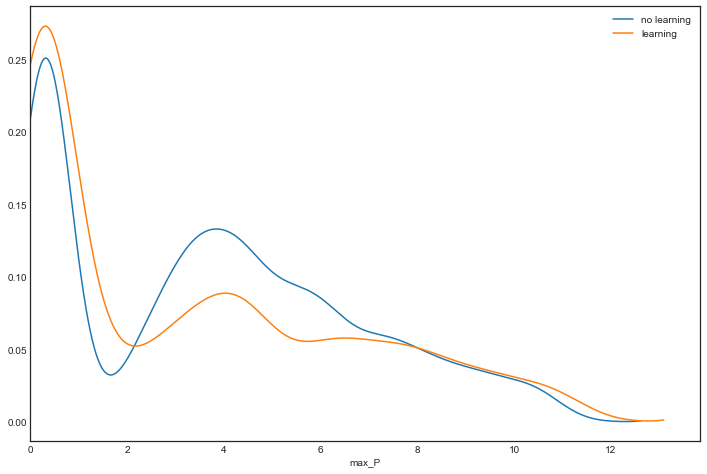

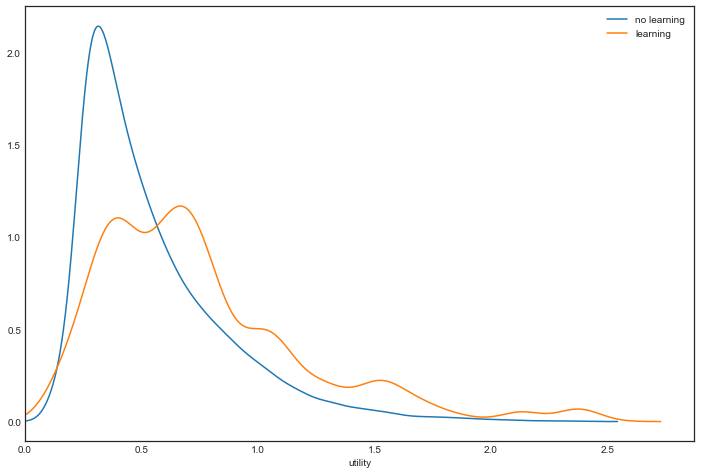

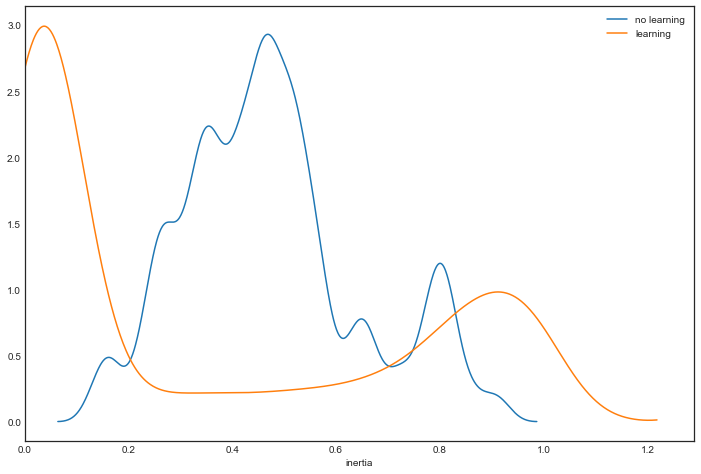

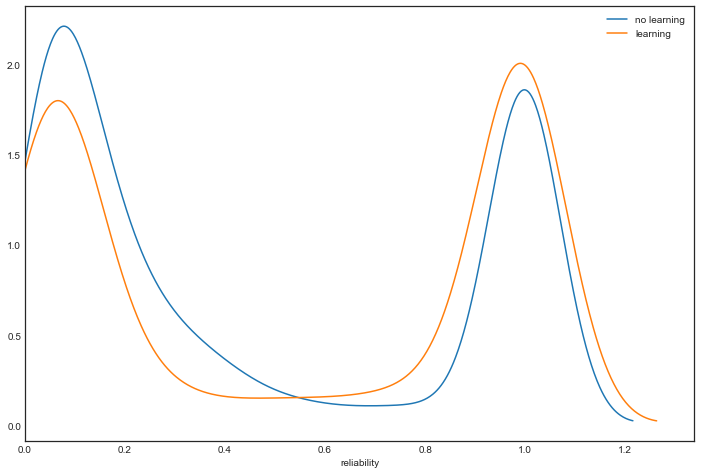

In [20]:
learning_outcomes = learning_results[1]
no_learning_outcomes = no_learning_results[1]

for outcome in outcomes.keys():
    fig = plt.figure()
    
    sns.kdeplot(no_learning_outcomes[outcome], gridsize=1000, label='no learning')
    sns.kdeplot(learning_outcomes[outcome], gridsize=1000, label='learning')
    ax.legend()
    ax = plt.gca()
    ax.autoscale(True)
    ax.set_xlabel(outcome)
    ax.set_xlim(xmin=0)
plt.show()

## interpretation of results

quite clearly, the formulation with endogenous learning produces better results than the no learning formulation if tested over a sampling of deeply uncertain states.

the second insight is that we still have plenty of cases even with the learning formulation with low utility, high polution, and low reliability. Thus, learning only partially addresses deep uncertainty. 